# Piechart Figures
- The first figure shows the breakdown of each module's synaptic connection location on the oviIN neuron body. This gives us an idea of how the modularity sorts the pre-synaptic connectome
- The second figure shows where all the synapses in the pre-synaptic connectome are made, broken down by the module that the pre-synaptic neuron is sorted into at 0.0 resolution

This file is easily adjusted to any dataset in the v1.2.1.

Written by Rhessa Weber Langstaff

In [41]:
# Imports
import os
import time
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["font.sans-serif"] = "Helvetica"

from neuprint import Client
from neuprint import fetch_synapse_connections, NeuronCriteria as NC, fetch_all_rois, fetch_primary_rois, fetch_adjacencies
from neuprint import fetch_roi_hierarchy, fetch_mean_synapses, SynapseCriteria as SC, fetch_simple_connections

hemibrain_version = "v1.2.1"

auth_token_file = open("/Users/rweberla/flybrain-clustering-rhessa/flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + hemibrain_version, token=auth_token)
    #log_msg("neuprint Client set up as `np_Client`, version", np_client.fetch_version())
except:
    np_client = None
    #log_msg("neuprint Client set up failed!")

Read in dataframe with super, l1, l2, l3, and l4. Created this file by following the output of the fetch_roi_hierarchy function. Super column is larger functional groups that we decided using Nomenclature paper (link)

In [42]:
roi_df = pd.read_excel('/Users/rweberla/flybrain-clustering-rhessa/all_roi_df.xlsx')
roi_df

,Super,Super_split,L1,L2,L3,L4,Color,Color2
0,AL,AL(L),AL(L),AL(L),NaN,NaN,cadetblue,NaN
1,AL,NaN,NaN,AL-D(L),NaN,NaN,NaN,cadetblue
2,AL,NaN,NaN,AL-DA2(L),NaN,NaN,NaN,cadetblue
3,AL,NaN,NaN,AL-DA3(L),NaN,NaN,NaN,cadetblue
4,AL,NaN,NaN,AL-DA4m(L),NaN,NaN,NaN,cadetblue
...,...,...,...,...,...,...,...,...
225,VMNP,NaN,NaN,VES(L),NaN,NaN,NaN,firebrick
226,VMNP,NaN,NaN,VES(R),NaN,NaN,NaN,firebrick
227,AL,AL(L),mALT(L),mALT(L),NaN,NaN,cadetblue,NaN
228,AL,AL(R),mALT(R),mALT(R),NaN,NaN,cadetblue,NaN


In [43]:
# Different levels of ROI can be accessed using the dropna() function
roi_super = roi_df['Super'].dropna()
roi_super_split = roi_df['Super_split'].dropna()
roi_l1 = roi_df['L1'].dropna()

In [44]:
# Adjust dataset here
direct = "modularity_runs/0.0/"
filename = "0-0_98765.txt"

ins_r = pd.read_csv(os.path.join(direct, filename), sep=" ", header=None, names=["id", "0.0"])
ins_r.head()
ins_r

,id,0.0
0,1003215282,1
1,1005952640,2
2,1006928515,3
3,1007260806,3
4,1008024276,4
...,...,...
1827,987117151,2
1828,987273073,6
1829,988567837,5
1830,988909130,5


In [45]:
# Fetch synaptic connections to the oviINr, can take around 30 seconds
ids = ins_r["id"]
roi_info = fetch_synapse_connections(NC(bodyId=ids), NC(bodyId=423101189), batch_size=1000)
roi_info

  0%|          | 0/18782 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]

,bodyId_pre,bodyId_post,roi_pre,roi_post,x_pre,y_pre,z_pre,x_post,y_post,z_post,confidence_pre,confidence_post
0,796889169,423101189,SMP(R),SMP(R),23373,32251,13044,23358,32282,13050,0.990,0.469301
1,796889169,423101189,SMP(R),SMP(R),22244,27537,12483,22226,27529,12490,0.792,0.617000
2,800588608,423101189,SMP(R),SMP(R),22806,30682,12514,22806,30692,12487,0.968,0.673414
3,796755936,423101189,SMP(R),SMP(R),21571,35158,14105,21564,35145,14113,0.983,0.997687
4,796755936,423101189,SMP(R),SMP(R),23040,31908,12238,23021,31907,12242,0.964,0.993469
...,...,...,...,...,...,...,...,...,...,...,...,...
18777,821686394,423101189,IB,IB,24215,16528,21699,24219,16526,21672,0.718,0.985000
18778,821686394,423101189,VES(R),VES(R),23040,22648,28280,23057,22666,28260,0.910,0.534000
18779,821686394,423101189,VES(R),VES(R),23042,22640,28253,23057,22664,28259,0.785,0.465808
18780,821686394,423101189,VES(R),VES(R),23202,23713,28967,23218,23729,28967,0.862,0.898703


## Synapses on oviIN breakdown

Here we pull all the connections made on the oviIN, specifically their super ROI grouping. These are grouped by cluster as well to see how each cluster breaksdown.

In [46]:
# Drop all unnecessary columns
roi_info_small = roi_info[['bodyId_pre', 'roi_post']]

# Collapse on roi_post and count the number of synapses in a new column called weight
roi_info_grouped = roi_info_small.groupby(['roi_post', 'bodyId_pre']).size().reset_index(name='weight')

# rename roi_post to roi
roi_info_grouped = roi_info_grouped.rename(columns = {'roi_post':'roi', 'bodyId_pre':'bodyId'})

In [47]:
# change weight to count
roi_info_grouped = roi_info_grouped.rename(columns = {'weight':'count'})

ins_r_e = pd.merge(ins_r, roi_info_grouped, left_on='id', right_on='bodyId', how='inner')


In [48]:
# Parameters needed for plotting
clusters = ins_r_e["0.0"].unique()
super_title = 'OviINr Input Connectome'
label_threshold = 1
color_dict = {'SNP': 'cornflowerblue', 'VMNP': 'firebrick', 'LX': 'blueviolet', 'INP': 'green'}
roi_super_dict = {'SMP(R)': 'SNP', 'SMP(L)': 'SNP', 'SIP(R)': 'SNP', 'SIP(L)': 'SNP', 'VES(R)': 'VMNP', 'LAL(R)': 'LX', 'IB': 'INP', 'CRE(R)': 'INP', 'CRE(L)': 'INP', 'ATL(R)': 'INP', 'ATL(L)': 'AL', 'VES(L)': 'VMNP', 'GOR(R)': 'VMNP', 'GOR(L)': 'VMNP', 'SPS(R)': 'VMNP', 'SPS(L)': 'VMNP', 'FLA(R)': 'PENP', 'FLA(L)': 'PENP', 'PENP': 'PENP', 'AL': 'AL', 'PENP': 'PENP'}
weight_threshold = 1
plot_labels = ['a.', 'b.', 'c.', 'd.', 'e.', 'f.', 'g.']
less_clusters = True

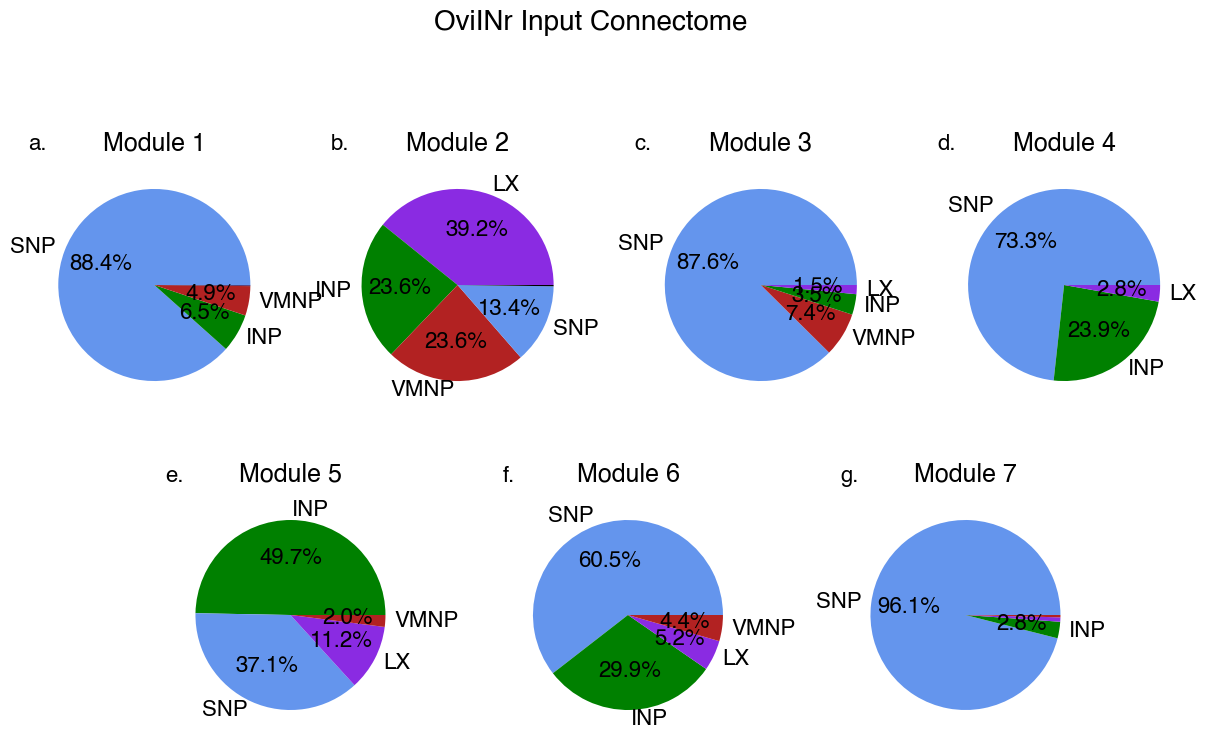

In [39]:
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
plt.suptitle(super_title, fontsize=20)
for i in clusters: 
        roi_grouped = ins_r_e[ins_r_e['0.0'] == i].groupby('roi', as_index=False).agg({'count': 'sum'})
        
        # Assign preferred roi
        roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
        roi_grouped = roi_grouped.drop(columns=['roi'])

        # Add up total weight for the super roi
        roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'count':'sum'})  
        roi_total = roi_grouped[roi_grouped['count'] > 1].sort_values(by='count', ascending=False)

        # Assign color
        roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
        # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
        data = roi_total[roi_total['count'] > weight_threshold].sort_values(by='count', ascending=False)
    
        # plot pie chart by value counts without none
        w, text, at = ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].pie(data['count'], labels = data['super'], colors = data['color'], autopct='%.1f%%',textprops={'fontsize': 16},radius=0.95, startangle=0)
        for t, x in enumerate(at):
            # Convert third part of x from string to float
            z = float(x.get_text().split()[0][:-1])
            if z <= label_threshold:
                    text[t].set_text('')
                    at[t].set_text('')
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title('Module ' + str(i), fontsize=18)
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title(plot_labels[i-1], fontweight='bold', loc='left', fontsize=16)

# Adjust subplot dimensions if less_clusters is True (for connectomes with odd number of clusters)
if less_clusters:
    fig.delaxes(ax[1, 3])
    # move bottom 3 axes to the middle
    ax[1, 0].set_position([0.05, 0.25, 0.5, 0.25])
    ax[1, 1].set_position([0.3, 0.25, 0.45, 0.25])
    ax[1, 2].set_position([0.55, 0.25, 0.4, 0.25])


In [40]:
fig.savefig("figures/roibreakdown_pie.svg", format="svg")

## Portionality Plot

We want to see how the input connectome's synapses breakdown by cluster. This is done by finding the portion of connections an input neuron makes in each ROI compared to all the connections it makes. This is then adjusted into the Super ROI and added up as total portions.

In [22]:
# Pull presynpatic neurons outputs and input connections, takes about a minute
ids = ins_r["id"]
_, roi_info_p = fetch_adjacencies(NC(bodyId=ids), None)

_, roi_info_in_p = fetch_adjacencies(None, NC(bodyId=ids))

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [23]:
# Combine input and output roi info
roi_out = roi_info_p[['bodyId_pre', 'roi', 'weight']]
roi_in = roi_info_in_p[['bodyId_post', 'roi', 'weight']]

roi_out = roi_out.rename(columns = {'bodyId_pre':'bodyId'})
roi_in = roi_in.rename(columns = {'bodyId_post':'bodyId'})

roi_both = pd.concat([roi_out, roi_in], axis=0)
roi_both

,bodyId,roi,weight
0,263674097,SMP(R),1
1,263674097,SMP(R),23
2,263674097,SIP(R),5
3,263674097,LH(R),1
4,263674097,SIP(R),1
...,...,...,...
830503,484890037,SMP(L),1
830504,485628489,SMP(L),1
830505,574511458,SMP(L),1
830506,733182574,SMP(L),2


For each bodyID i want to get a fraction of how many synapses (weight) were made in an roi over the total number of synapses made by that bodyID and put that portionality in a new column.

In [24]:
# Drop all unnecessary columns
grouped_p = roi_both[['bodyId', 'roi', 'weight']]

# I will first create a column that will contain the total number of synapses made by a bodyID
grouped_p['total'] = grouped_p.groupby('bodyId')['weight'].transform('sum')

# I will then create a new column that will contain the fraction of synapses made in an roi
# over the total number of synapses made by that bodyID
grouped_p['fraction'] = grouped_p['weight'] / grouped_p['total']


# I will drop the weight and total columns as they are no longer needed
grouped_p = grouped_p.drop(columns=['weight', 'total'])
grouped_p

,bodyId,roi,fraction
0,263674097,SMP(R),0.001007
1,263674097,SMP(R),0.023162
2,263674097,SIP(R),0.005035
3,263674097,LH(R),0.001007
4,263674097,SIP(R),0.001007
...,...,...,...
830503,484890037,SMP(L),0.000487
830504,485628489,SMP(L),0.002096
830505,574511458,SMP(L),0.000481
830506,733182574,SMP(L),0.000582


In this next dataframe we can see the cluster each neuron belongs in, the roi it falls into and the fraction of connections each neuron makes in that roi.

In [25]:
# Input modularity data for oviINr merged with the roi portionality data
in_r_p = pd.merge(ins_r, grouped_p, left_on='id', right_on='bodyId', how='inner')
in_r_p

,id,0.0,bodyId,roi,fraction
0,1003215282,1,1003215282,IB,0.003180
1,1003215282,1,1003215282,ICL(R),0.003180
2,1003215282,1,1003215282,ICL(R),0.001590
3,1003215282,1,1003215282,ICL(R),0.001590
4,1003215282,1,1003215282,IB,0.001590
...,...,...,...,...,...
1642780,989228019,5,989228019,CRE(R),0.000570
1642781,989228019,5,989228019,LAL(R),0.002281
1642782,989228019,5,989228019,CRE(R),0.001995
1642783,989228019,5,989228019,CRE(R),0.000855


         super    fraction           color
12         SNP  237.276490  cornflowerblue
4          INP   46.161365           green
13        VLNP   11.075751          orange
14        VMNP   10.505839       firebrick
8   NotPrimary    1.200471            navy
6           LX    1.120921      blueviolet
   super   fraction           color
5     LX  76.127516      blueviolet
13  VMNP  47.481268       firebrick
3    INP  37.953012           green
11   SNP  14.858206  cornflowerblue
12  VLNP  14.561297          orange
8     OL   2.057813       rosybrown
1     CX   1.801931          salmon
10  PENP   1.061366          orchid
0     AL   1.006697       cadetblue
   super    fraction           color
12   SNP  186.655606  cornflowerblue
4    INP   63.708223           green
13  VLNP   39.849234          orange
14  VMNP   20.688069       firebrick
6     LX    3.845632      blueviolet
9     OL    2.501225       rosybrown
   super    fraction           color
12   SNP  172.465424  cornflowerblue
2     

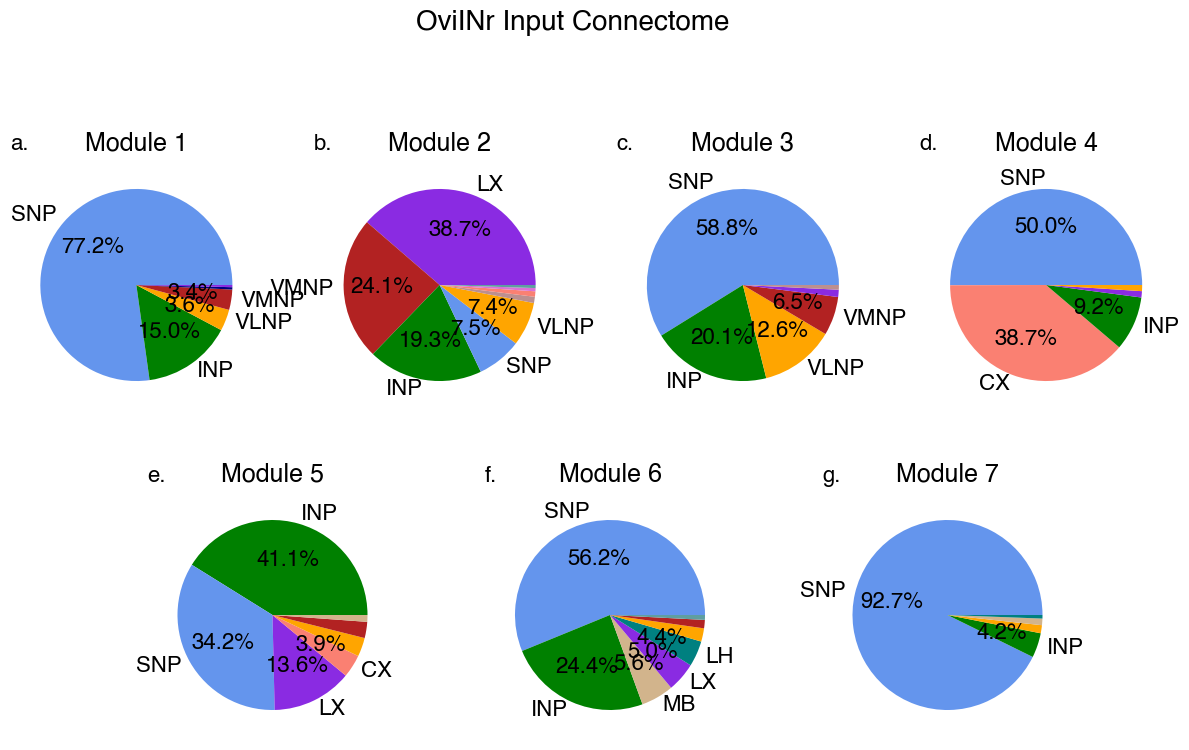

In [32]:
# Set color maps
color_dict = roi_df.set_index('Super')['Color'].dropna().to_dict()
roi_super_dict = roi_df.set_index('L2')['Super'].dropna().to_dict()

# set label-threshold
label_threshold = 3.35

# Plot
fig, ax = plt.subplots(2, 4, figsize=(15, 10))
plt.suptitle(super_title, fontsize=20)
for i in clusters: 
        roi_grouped = in_r_p[in_r_p['0.0'] == i].groupby('roi', as_index=False).agg({'fraction': 'sum'})

        # Assign preferred roi level (SUPER)
        roi_grouped['super'] = roi_grouped['roi'].map(roi_super_dict).fillna(roi_grouped['roi'])
        roi_grouped = roi_grouped.drop(columns=['roi'])

        # Add up total weight for the super roi
        roi_grouped = roi_grouped.groupby('super', as_index=False).agg({'fraction':'sum'})  
        roi_total = roi_grouped[roi_grouped['fraction'] > 1].sort_values(by='fraction', ascending=False)

        # Assign color
        roi_total['color'] = roi_total['super'].map(color_dict).fillna('black')
        
        # Filter roi_total by weight_threshold and sort by total in descending order (might not need to do this but just in case)
        data = roi_total[roi_total['fraction'] > weight_threshold].sort_values(by='fraction', ascending=False)
        print(data)
        # plot pie chart by value counts without none
        w, text, at = ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].pie(data['fraction'], labels = data['super'], colors = data['color'], autopct='%.1f%%',textprops={'fontsize': 16},radius=0.95, startangle=0)
        for t, x in enumerate(at):
            # Convert third part of x from string to float
            z = float(x.get_text().split()[0][:-1])
            if z <= label_threshold:
                    text[t].set_text('')
                    at[t].set_text('')
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title('Module ' + str(i), fontsize=18)
        ax[int((i-1)/int(len(clusters)/1.5)), (i-1)%int(len(clusters)/1.5)].set_title(plot_labels[i-1], fontweight='bold', loc='left', fontsize=16)

# Adjust subplot dimensions if less_clusters is True (for connectomes with odd number of clusters)
if less_clusters:
    fig.delaxes(ax[1, 3])
    # move bottom 3 axes to the middle
    ax[1, 0].set_position([0.05, 0.25, 0.5, 0.25])
    ax[1, 1].set_position([0.3, 0.25, 0.45, 0.25])
    ax[1, 2].set_position([0.55, 0.25, 0.4, 0.25])

In [34]:
fig.savefig("figures/portionality_pie.svg", format="svg")